<div align="center">
    <div><img src="../assets/redis_logo.svg" style="width: 130px"> </div>
    <div style="display: inline-block; text-align: center; margin-bottom: 10px;">
        <span style="font-size: 36px;"><b>Multi-document RAG based on LangGraph with Redis Retrieval Agent using Ollama and React agents</b></span>
        <br />
    </div>
    <br />
</div>

# 
[Retrieval Agents](https://python.langchain.com/docs/use_cases/question_answering/conversational_retrieval_agents) are useful when we want to make decisions about whether to retrieve from an index. Here we construct the same single index of 10Ks with metadata that we tried in notebook 04.

To implement a Redis retrieval agent, we simply need to give an LLM access to a Redis retriever tool.

We can incorporate this into [LangGraph](https://python.langchain.com/docs/langgraph).

## Environment Setup

In [1]:
import os
import warnings
import dotenv
# mute warnings
warnings.filterwarnings('ignore')
# load env vars from .env file
dotenv.load_dotenv()
dir_path = os.getcwd()
parent_directory = os.path.dirname(dir_path)
os.environ["ROOT_DIR"] = parent_directory
REDIS_URL = os.getenv("REDIS_URL")
print(dir_path)
print(parent_directory)

/Users/rouzbeh.farahmand/PycharmProjects/boa-financial-rag-workshop/2_RAG_patterns_with_redis
/Users/rouzbeh.farahmand/PycharmProjects/boa-financial-rag-workshop


### Install Python Dependencies

In [2]:
%pip install -r $ROOT_DIR/requirements.txt

Note: you may need to restart the kernel to use updated packages.


### SentenceTransformerEmbeddings Models Cache folder
We are using `SentenceTransformerEmbeddings` in this demo and here we specify the cache folder. If you already downloaded the models in a local file system, set this folder here, otherwise the library tries to download the models in this folder if not available locally.

In particular, this models will be downloaded if not present in the cache folder:

models/models--sentence-transformers--all-MiniLM-L6-v2

In [3]:
#setting the local downloaded sentence transformer models f
os.environ["TRANSFORMERS_CACHE"] = f"{parent_directory}/models"

In [4]:
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embeddings = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",
                                           cache_folder=os.getenv("TRANSFORMERS_CACHE", f"{parent_directory}/models"))

### Build your Redis index 
Skip this section if you have already built your index in previous notebook.


In [5]:
from redisvl.index import SearchIndex
from redisvl.schema import IndexSchema
from redis import Redis
index_name = 'langchain'
prefix = 'chunk'
schema = IndexSchema.from_yaml('sec_index.yaml')
client = Redis.from_url(REDIS_URL)
# create an index from schema and the client
index = SearchIndex(schema, client)
index.create(overwrite=True, drop=True)

12:08:30 redisvl.index.index INFO   Index already exists, overwriting.


In [6]:
# Skip if you have already done populated your index.
from ingestion import get_sec_data
from ingestion import redis_bulk_upload

sec_data = get_sec_data()

 ✅ Loaded doc info for  110 tickers...


In [7]:
redis_bulk_upload(sec_data, index, embeddings, tickers=['AAPL'])

✅ Loaded 108 10K chunks for ticker=AAPL from AAPL-2021-10K.pdf
✅ Loaded 94 10K chunks for ticker=AAPL from AAPL-2023-10K.pdf
✅ Loaded 103 10K chunks for ticker=AAPL from AAPL-2022-10K.pdf
✅ Loaded 27 earning_call chunks for ticker=AAPL from 2018-May-01-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2019-Oct-30-AAPL.txt
✅ Loaded 30 earning_call chunks for ticker=AAPL from 2016-Jan-26-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2020-Jul-30-AAPL.txt
✅ Loaded 30 earning_call chunks for ticker=AAPL from 2017-Aug-01-AAPL.txt
✅ Loaded 29 earning_call chunks for ticker=AAPL from 2020-Jan-28-AAPL.txt
✅ Loaded 34 earning_call chunks for ticker=AAPL from 2016-Apr-26-AAPL.txt
✅ Loaded 29 earning_call chunks for ticker=AAPL from 2017-Jan-31-AAPL.txt
✅ Loaded 28 earning_call chunks for ticker=AAPL from 2019-Apr-30-AAPL.txt
✅ Loaded 26 earning_call chunks for ticker=AAPL from 2017-Nov-02-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2016-Oct-25-AAPL.tx

## Redis as a Langchain Retriever


In [8]:
from langchain_community.vectorstores import Redis as LangChainRedis
from utils import create_langchain_schemas_from_redis_schema

index_name = 'langchain'

vec_schema , main_schema = create_langchain_schemas_from_redis_schema('sec_index.yaml')

rds = LangChainRedis.from_existing_index( embedding = embeddings, 
                                          index_name = index_name, 
                                          schema = main_schema)
redis_retriever = rds.as_retriever()


Test if the Redis index is working and returning relevant document.

In [9]:
rds.similarity_search(query="Apple in 2022", k=4, distance_threshold=0.8)

[Document(page_content='The Company’s global operations are subject to complex and changing laws and regulations on subjects, including antitrust; privacy, data security and data localization; consumer protection; advertising, sales, billing and e-commerce; financial services and technology; product liability; intellectual property ownership and infringement; digital platforms; internet, telecommunications, and mobile communications; media, television, film and digital content; availability of third-party software applications and services; labor and employment; anticorruption; import, export and trade; foreign exchange controls and cash repatriation restrictions; anti–money laundering; foreign ownership and investment; tax; and environmental, health and safety, including electronic waste, recycling, and climate change.\n\nApple Inc. | 2022 Form 10-K | 13', metadata={'id': 'chunk:AAPL-2022-10K.pdf-5908b7a4-c63d-44d6-8b20-a2a4d7932e2f', 'chunk_id': 'AAPL-2022-10K.pdf-5908b7a4-c63d-44d6-

Now we create a Redis retriever tool.

In [10]:
from langchain_core.prompts import PromptTemplate
from langgraph.graph.message import add_messages
import operator
from typing import Annotated, TypedDict, Union, Sequence, List
from langchain.agents import create_react_agent
from langchain_community.chat_models import ChatOllama
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolExecutor, ToolInvocation

@tool
def get_relevant_docs_from_redis(input: str):
    """
    Get the relevant docs from a redis query.
    """
    
    print(f"RFD-DEBUG: ======= REDIS TOOL RESPONSE for {input} ===============")
    redis_response = rds.similarity_search(query=input, k=4, distance_threshold=0.8)
    
    
    print(redis_response)
    print(f"RFD-DEBUG: =======REDIS TOOL RESPONSE = got {len(redis_response)} docs ===============")
    return redis_response


@tool
def response_to_irrelevant_questions(input: str):
    """
    In case of getting questions that are not relevant to finance prepare a response.
    """
    
    default_response = [f"Your question does not seem to be relevant to finance. Please only ask questions that are relevant to financials of companies that are usually reported in 10K or earning calls.>"]
    
    return default_response


tools = [get_relevant_docs_from_redis, response_to_irrelevant_questions]
tool_executor = ToolExecutor(tools)
tool_names = list(tool_executor.tool_map.keys())

class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[Sequence[BaseMessage], add_messages]
    filters : str
    question_relevancy: str
    generation: str
    documents: List[str]


agent_model = ChatOllama(model="llama3")
agent_local_prompt = PromptTemplate(
        template="""
            You are an assistant for question-answering tasks about financial documents. If you don't think the question is relevant to financial documents, then tell the user you don't have relevant tools to answer them. And do not execute any tools. If you think the question is relevant to financial documents, then, use the tools provided to you to answer them:

            {tools}
            Question: the input question you must answer.
            Thought: you should always think about what to do. 
            Action: the action to take, should be one of [{tool_names}] or the end of conversation with a response you get from using a tool called `response_to_irrelevant_questions`. 
            Action Input: the input to the action
            Observation: the result of the action is a snippet of financial information related to a company
            ... (this Thought/Action/Action Input/Observation can repeat N times)
            Action Input: Other agents will resolve the answer to the question so don't try to answer the question yourself. Just run the tools and retrieve the related documents. 
            
            Question: {input}
            Thought:{agent_scratchpad}
            """,
        input_variables=["tools","tool_names", "input","agent_scratchpad"],
    )


agent_runnable = create_react_agent(agent_model, tools, agent_local_prompt)


In [11]:
tool_names

['get_relevant_docs_from_redis', 'response_to_irrelevant_questions']

In [12]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

llm = ChatOllama(model='llama3', format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {input} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamable or explanation.""",
    input_variables=["input", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "apple revenue in 2022"
docs = redis_retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"input": question, "document": doc_txt}))

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


{'score': 'no'}


In [13]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate,PromptTemplate

# Prompt
#prompt = hub.pull("rlm/rag-prompt")
gen_local_prompt = PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:")

# LLM
gen_llm = ChatOllama(model="llama3")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
gen_rag_chain = gen_local_prompt | gen_llm | StrOutputParser()

q="what is the deferred apple revenue in 2022?"
context = """As of September 24, 2022 and September 25, 2021, 
            the Company had total deferred revenue of $12.4 
            billion and $11.9 billion, respectively. As of 
            September 24, 2022, the Company expects 64% of 
            total deferred revenue to be realized in less """

    # Run Gen LLM
response = gen_rag_chain.invoke({"context": context, "question": q})
print(response)

Based on the provided context, I don't know the specific deferred apple revenue for 2022. However, it mentions that as of September 24, 2022, the Company had total deferred revenue of $12.4 billion.


In [14]:
### Question topic detection

# LLM
topic_llm = ChatOllama(model="llama3")

# Prompt
topic_prompt = PromptTemplate(
    template="""Your task is to assign a topic for a given financial question and formulate a new question related to the topic that you found. Only return a valid JSON as your results. You have to determine if the answer for the question is can be found in "earning_calls" or "10K" financial filings. So choose either "earning_calls" or "10K" as the assigned topic. If you are unsure assign `None`. Give a topic 'earning_call' or '10K' as a JSON with a single key 'topic'. Also add a new key called 'new_question' and try to rewrite the given question based on the topic you detected. If the detected topic is None or your could find a relevance of the questions to those topics return 'None' as the new question. Only return a valid JSON objects as your response. If you have new information or Notes, add a new field in the JSON called `note` and add your explanation in that `note` field. the output should be only an JSON: \n\n {question}.  \n """,
    input_variables=["question"],
)

topic_finder = topic_prompt | topic_llm | JsonOutputParser()
topic_finder.invoke({"question": "what is the aapl revenue in 2022?"})

{'topic': '10K',
 'new_question': "What was Apple's total revenue for the year ended December 31, 2022?",
 'note': ''}

In [15]:
topic_finder.invoke({"question": "Why colorless green ideas are sleep furiously?"})

{'topic': 'None', 'new_question': 'None'}

In [16]:
from langchain_core.documents import Document
from typing import Literal
from custom_ners import get_redis_filters
from utils import *
# Plugin any new or existing query analysis/ query understanding/translation to your DSL here.
# you can have your own LTR/ query topic detection/ intent detection pipelines here.
def query_analysis(q):
    filters = get_redis_filters(q)
    print(f"inferred filters: {filters}")
    return filters

### Edges
def check_relevancy(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the asked question is relevant to our domain and if retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print(f"---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    print(f"state={state}")
    print(f"===========================================")
    
    input = state["input"]
    documents = state["documents"]
    question_relevancy = state["question_relevancy"]
    
    if question_relevancy == 'not_relevant':
        print(f"---DECISION: We have a question that is not RELEVANT to our docs- setting to generate ---")
        return "generate"
    
    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke({"input": input, "document": d})
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    
    if len(filtered_docs) > 0 :
        print(f"---DECISION: We have {len(filtered_docs)} RELEVANT docs- setting to generate---")
        state["documents"] = filtered_docs
        return "generate"
    else:
        print("---DECISION: NO DOCS are RELEVANT, try gain by rewriting the query---")
        return "rewrite"

### Nodes

def execute_tools(state):
    

    print("RFD-DEBUG: ======== Called `execute_tools`========")
    
    if state.get("agent_outcome"):
        messages = [state["agent_outcome"]]
        last_message = messages[-1]
        if last_message.tool is not None:
            tool_name = last_message.tool
            tool_input = last_message.tool_input
            print(f"Calling tool: {tool_name}")
        
            #That means we have an irrelevant question
            if tool_name == 'response_to_irrelevant_questions':
                action = ToolInvocation(
                tool=tool_name,
                tool_input=tool_input,
                )
                base_response = tool_executor.invoke(action)
                cleaned_response = str(base_response) 
                return {
                    "intermediate_steps": [(state["agent_outcome"], cleaned_response)],
                    "documents" : [],
                    "question_relevancy" :'not_relevant'
                }
            else:
                action = ToolInvocation(
                    tool=tool_name,
                    tool_input=tool_input,
                    )
                documents = tool_executor.invoke(action)
                cleaned_response = concat_docs(documents)
                print(f"====RFD DEBUG: ======== response from tool_executor= {len(documents)} ========")
                return {
                    "intermediate_steps": [(state["agent_outcome"], cleaned_response)],
                    "documents" : format_docs(documents),
                    "question_relevancy" :'relevant'
                    
                }
        else:
            cleaned_response = str(last_message.log)
            return {
                "intermediate_steps": [(state["agent_outcome"], cleaned_response)],
                "documents" : []
            }
    else:
        return {
                "messages" : [state],
                "documents" : []
            }
        
            


def agent(state):
    print(f"RFD-DEBUG:AGENT==========")
    print(f"RFD-DEBUG AGENT stare={str(state)}")
    print(f"RFD-DEBUG:============")
    try:
        agent_outcome = agent_runnable.invoke(state)
    except Exception as e:
        print(f"RFD-DEBUG AGENT ERROR: {str(e)}")
        return {"messages": [str(e)]}
    
    
    print(f"RFD-DEBUG:agent_outcome = {str(agent_outcome)}")
    return {"agent_outcome": agent_outcome}

def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("--- QUERY rewrite ---")
    def combine_filters(inferred_filters, doc_type_filter="10K", filter_strategy="AND"):
        if inferred_filters is None:
            return "@doc_type:{"+f"{doc_type_filter}"+"}"
        else:
            return "@doc_type:{"+f"{doc_type_filter}"+"} " + filter_strategy +f" ({inferred_filters})"
            
        
    question = state["input"]
    documents = state["documents"]
    q_filters = query_analysis(question)
    topic = topic_finder.invoke({"question": question})
    print(f"---QUERY rewrite---topic_finder={topic}")
    detected_topic = topic["topic"]
    
    
    if detected_topic != "None":
        print(f"---TOPIC: Question is Related to {detected_topic}---")
        q_filters = query_analysis(question)
        applied_filters = combine_filters(q_filters, doc_type_filter=detected_topic)
    else:
        applied_filters = combine_filters(q_filters)
        
    new_question = topic["new_question"]   
    if new_question != "None":
        print(f"---TOPIC: new_question is {new_question}---")
        rewrite_question = new_question
    else:
        rewrite_question = question
        
    print(f"---QUERY rewrite for QUESTION={question} with filters={applied_filters}---")
    
    return {"documents": documents, "input": rewrite_question, "filters": applied_filters}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    final_docs = state["documents"]
    final_question = state["input"]
    if final_docs is not None and len(final_docs) > 0:
        final_context = "\n".join(final_docs)
    
    print(f"RFD-DEBUG:GENERATE==========")
    print(f"RFD-DEBUG:GENERATE=== question={final_question}")
    print(f"RFD-DEBUG:GENERATE=== context={final_context}")

    # Run Gen LLM
    generated_answer = gen_rag_chain.invoke({"context": str(final_context)[0:1000], "question": final_question})
    print(f"RFD-DEBUG:GENERATE=== generation={generated_answer}")
    return {"messages": [generated_answer], "generation": generated_answer}

 ✅ Loaded doc info for  110 tickers...


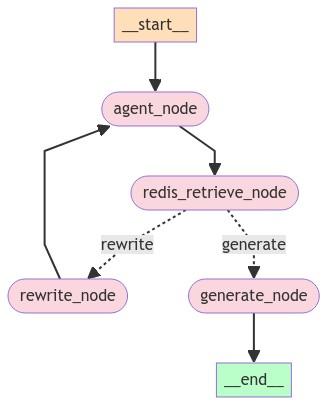

In [17]:
from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)


# Define the nodes we will cycle between
workflow.add_node("agent_node", agent)  # agent
workflow.add_node("redis_retrieve_node", execute_tools)
workflow.add_edge("agent_node", 'redis_retrieve_node')
workflow.add_node("rewrite_node", rewrite)
workflow.add_edge("rewrite_node", "agent_node")
# Decide whether to retrieve
workflow.add_conditional_edges(
    "redis_retrieve_node",
    check_relevancy,
    {
        # Translate the condition outputs to nodes in our graph
        "rewrite": "rewrite_node",
        "generate": "generate_node",
    },
)

workflow.add_node("generate_node", generate)
workflow.add_edge("generate_node", END)

workflow.set_entry_point("agent_node")

# Compile
graphapp = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graphapp.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass


In [ ]:
import pprint

inputs = {
    "input":"What was the deferred revenue of aapl in 2022?",
    "messages": [
        ("user", "What was the performance of aapl revenue in 2022?"),
    ]
}
for output in graphapp.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

RFD-DEBUG:AGENT==========
RFD-DEBUG AGENT stare={'input': 'What was the deferred revenue of aapl in 2022?', 'chat_history': None, 'agent_outcome': None, 'intermediate_steps': [], 'messages': [('user', 'What was the performance of aapl revenue in 2022?')], 'filters': None, 'question_relevancy': None, 'generation': None, 'documents': None}
RFD-DEBUG:============
RFD-DEBUG:agent_outcome = tool='get_relevant_docs_from_redis' tool_input='What was the deferred revenue of AAPL in 2022?"\n\nPlease wait while I retrieve the relevant documents from Redis' log='Thought: The question seems relevant to financial documents, specifically about Apple Inc.\'s (AAPL) financial data.\n\nAction: get_relevant_docs_from_redis\n\nAction Input: "What was the deferred revenue of AAPL in 2022?"\n\nPlease wait while I retrieve the relevant documents from Redis'
"Output from node 'agent_node':"
'---'
{ 'agent_outcome': AgentAction(tool='get_relevant_docs_from_redis', tool_input='What was the deferred revenue of A

In [ ]:
import pprint

inputs2 = {
    "input":"Why colorless green ideas are furiously sleeping?",
    "messages": [
        ("user", "Why colorless green ideas are furiously sleeping?"),
    ]
}

for output2 in graphapp.stream(inputs2):
    for key2, value2 in output2.items():
        pprint.pprint(f"Output from node '{key2}':")
        pprint.pprint("---")
        pprint.pprint(value2, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")